In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

from keras.models import Model
from keras.layers import GRU, concatenate, Input, Dense

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
weatherData = np.load('FullweatherData.npy')
df = pd.DataFrame(np.load('FireData.npy'), columns=['day', 'lat', 'lon', 'tarray', 'xybinarray', 'fire']).astype(int, copy=False)

In [3]:
def moddf(df):
    df0 = df.drop(['tarray', 'xybinarray'],axis=1).values
    df0 = (df0-df0.mean())/ df0.std()
    
    tarray = df['tarray'].values
    xybinarray = df['xybinarray'].values
    df1 = np.empty((len(df),31,4))
    for i in range(0,31):
        for j in range(0,4):
            df1[:,i,j] = weatherData[tarray-i, xybinarray,j]
    # Normalize features
    df1 = (df1-df1.mean())/ df1.std()
    
    return df0, df1

xdf = df.drop('fire',axis=1)
y = df['fire'].values
x0, x1 = moddf(xdf)
X0, X0_test, X1, X1_test, y, y_test = train_test_split(
    x0, x1, y, test_size=0.1, shuffle=True)
X0_train, X0_val, X1_train, X1_val, y_train, y_val = train_test_split(
    X0, X1, y, test_size=0.1, shuffle=True)

In [28]:
nUnits = 10

x0 = Input(shape=(3,))
x1 = Input(shape=(31,4))
inistate = Dense(nUnits, activation = 'relu')(x0)
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(1, activation='sigmoid', return_sequences=False)(x)

model = Model(inputs=[x0,x1], outputs=x)
model.compile(optimizer='adam',
              loss='binary_crossentropy')
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0., patience=10)]

batchsize = 64
history = model.fit([X0_train,X1_train], y_train, epochs=1, batch_size=batchsize,verbose=2,callbacks=callbacks,shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

Train on 913093 samples, validate on 101455 samples
Epoch 1/1
959s - loss: 0.6056 - val_loss: 0.5941


Train on 913093 samples, validate on 101455 samples
Epoch 1/10
151s - loss: 0.6218 - acc: 0.6504 - val_loss: 0.6059 - val_acc: 0.6724
Epoch 2/10
145s - loss: 0.6004 - acc: 0.6753 - val_loss: 0.5958 - val_acc: 0.6796
Epoch 3/10
147s - loss: 0.5952 - acc: 0.6786 - val_loss: 0.5922 - val_acc: 0.6820
Epoch 4/10
149s - loss: 0.5922 - acc: 0.6809 - val_loss: 0.5893 - val_acc: 0.6844
Epoch 5/10
148s - loss: 0.5895 - acc: 0.6834 - val_loss: 0.5863 - val_acc: 0.6864
Epoch 6/10
152s - loss: 0.5869 - acc: 0.6855 - val_loss: 0.5842 - val_acc: 0.6874
Epoch 7/10
154s - loss: 0.5851 - acc: 0.6867 - val_loss: 0.5860 - val_acc: 0.6868
Epoch 8/10
155s - loss: 0.5841 - acc: 0.6874 - val_loss: 0.5862 - val_acc: 0.6845
Epoch 9/10
151s - loss: 0.5832 - acc: 0.6879 - val_loss: 0.5809 - val_acc: 0.6898
Epoch 10/10
155s - loss: 0.5826 - acc: 0.6880 - val_loss: 0.5817 - val_acc: 0.6892


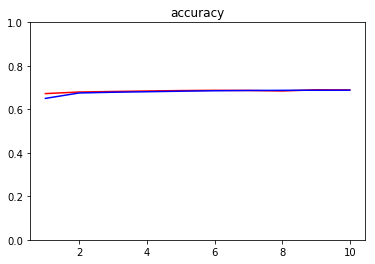

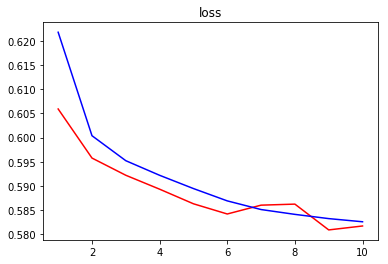

In [29]:
nUnits = 10
batchsize = 256
nepochs = 10

x0 = Input(shape=(3,))
x1 = Input(shape=(31,4))
inistate = Dense(nUnits, activation = 'relu')(x0)
x = GRU(nUnits, return_sequences=False)(x1, initial_state = inistate) 
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[x0,x1], outputs=x)
model.compile(optimizer='adam', metrics=['acc'],
              loss='binary_crossentropy')

# I don't need early stopping right now, I want to test the model after small number of epochs.
#callbacks = [EarlyStopping(monitor='val_loss', min_delta=0., patience=10)]
#history = model.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2,callbacks=callbacks,shuffle=True, 
#          validation_data=([X0_val,X1_val], y_val))

history = model.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

xaxis=range(1,len(history.history['val_acc'])+1)
plt.plot(xaxis, history.history['val_acc'], 'r', xaxis, history.history['acc'], 'b')
plt.ylim((0.,1.))
plt.title('accuracy')
plt.show()

plt.plot(xaxis, history.history['val_loss'], 'r', xaxis, history.history['loss'], 'b')
plt.title('loss')
plt.show()

Train on 913093 samples, validate on 101455 samples
Epoch 1/5
159s - loss: 0.6239 - acc: 0.6457 - val_loss: 0.6140 - val_acc: 0.6580
Epoch 2/5
154s - loss: 0.6067 - acc: 0.6671 - val_loss: 0.6043 - val_acc: 0.6700
Epoch 3/5
155s - loss: 0.6038 - acc: 0.6699 - val_loss: 0.6018 - val_acc: 0.6717
Epoch 4/5
158s - loss: 0.6017 - acc: 0.6715 - val_loss: 0.6001 - val_acc: 0.6733
Epoch 5/5
159s - loss: 0.6000 - acc: 0.6734 - val_loss: 0.5982 - val_acc: 0.6747


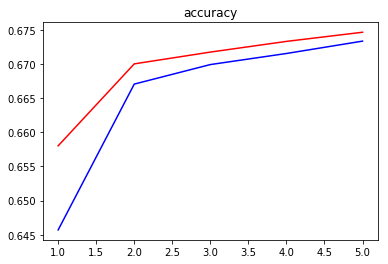

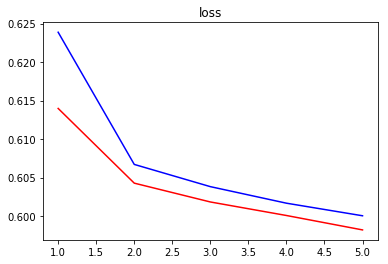

In [30]:
nUnits = 20
batchsize = 256
nepochs = 5

x0 = Input(shape=(3,))
x1 = Input(shape=(31,4))
inistate = Dense(nUnits, activation = 'relu')(x0)
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
# I should have put x not x1 there, the first GRU and the localization info are not used. It is surprising it works so well.
# Though it explains why the time per epoch didn't increase.
x = GRU(nUnits, return_sequences=False)(x1) 
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[x0,x1], outputs=x)
model.compile(optimizer='adam', metrics=['acc'],
              loss='binary_crossentropy')

history = model.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

xaxis=range(1,len(history.history['val_acc'])+1)
plt.plot(xaxis, history.history['val_acc'], 'r', xaxis, history.history['acc'], 'b')
plt.title('accuracy')
plt.show()

plt.plot(xaxis, history.history['val_loss'], 'r', xaxis, history.history['loss'], 'b')
plt.title('loss')
plt.show()

Train on 913093 samples, validate on 101455 samples
Epoch 1/10
155s - loss: 0.5982 - acc: 0.6748 - val_loss: 0.5969 - val_acc: 0.6756
Epoch 2/10
158s - loss: 0.5968 - acc: 0.6756 - val_loss: 0.5976 - val_acc: 0.6762
Epoch 3/10
158s - loss: 0.5955 - acc: 0.6767 - val_loss: 0.5948 - val_acc: 0.6774
Epoch 4/10
157s - loss: 0.5945 - acc: 0.6779 - val_loss: 0.5944 - val_acc: 0.6776
Epoch 5/10
153s - loss: 0.5936 - acc: 0.6787 - val_loss: 0.5964 - val_acc: 0.6765
Epoch 6/10
159s - loss: 0.5927 - acc: 0.6794 - val_loss: 0.5926 - val_acc: 0.6782
Epoch 7/10
149s - loss: 0.5919 - acc: 0.6803 - val_loss: 0.5913 - val_acc: 0.6792
Epoch 8/10
148s - loss: 0.5912 - acc: 0.6806 - val_loss: 0.5911 - val_acc: 0.6784
Epoch 9/10
147s - loss: 0.5906 - acc: 0.6813 - val_loss: 0.5903 - val_acc: 0.6804
Epoch 10/10
148s - loss: 0.5901 - acc: 0.6817 - val_loss: 0.5905 - val_acc: 0.6805


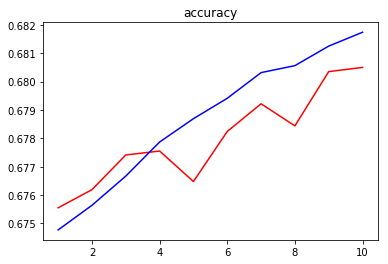

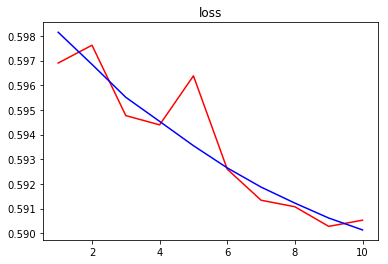

In [31]:
# Continue fitting
batchsize = 256
nepochs = 10

history = model.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

xaxis=range(1,len(history.history['val_acc'])+1)
plt.plot(xaxis, history.history['val_acc'], 'r', xaxis, history.history['acc'], 'b')
plt.title('accuracy')
plt.show()

plt.plot(xaxis, history.history['val_loss'], 'r', xaxis, history.history['loss'], 'b')
plt.title('loss')
plt.show()

Train on 913093 samples, validate on 101455 samples
Epoch 1/20
280s - loss: 0.6058 - acc: 0.6657 - val_loss: 0.5909 - val_acc: 0.6828
Epoch 2/20
278s - loss: 0.5893 - acc: 0.6823 - val_loss: 0.5837 - val_acc: 0.6878
Epoch 3/20
280s - loss: 0.5830 - acc: 0.6871 - val_loss: 0.5785 - val_acc: 0.6895
Epoch 4/20
280s - loss: 0.5789 - acc: 0.6899 - val_loss: 0.5782 - val_acc: 0.6925
Epoch 5/20
291s - loss: 0.5758 - acc: 0.6928 - val_loss: 0.5730 - val_acc: 0.6950
Epoch 6/20
298s - loss: 0.5744 - acc: 0.6939 - val_loss: 0.5757 - val_acc: 0.6935
Epoch 7/20
281s - loss: 0.5730 - acc: 0.6949 - val_loss: 0.5701 - val_acc: 0.6968
Epoch 8/20
273s - loss: 0.5716 - acc: 0.6958 - val_loss: 0.5711 - val_acc: 0.6970
Epoch 9/20
274s - loss: 0.5708 - acc: 0.6966 - val_loss: 0.5707 - val_acc: 0.6971
Epoch 10/20
279s - loss: 0.5699 - acc: 0.6972 - val_loss: 0.5698 - val_acc: 0.6979
Epoch 11/20
273s - loss: 0.5693 - acc: 0.6980 - val_loss: 0.5720 - val_acc: 0.6950
Epoch 12/20
275s - loss: 0.5686 - acc: 0.698

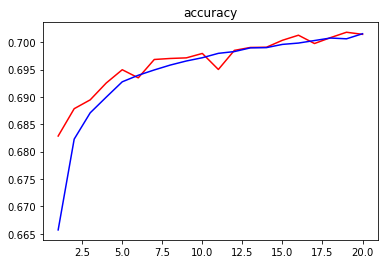

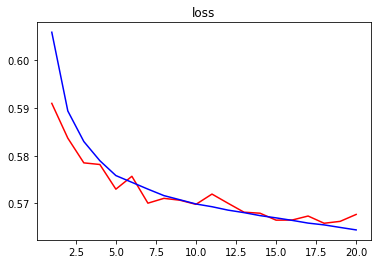

In [32]:
nUnits = 20
batchsize = 256
nepochs = 20

x0 = Input(shape=(3,))
x1 = Input(shape=(31,4))
inistate = Dense(nUnits, activation = 'relu')(x0)
inistate1 = Dense(nUnits, activation = 'relu')(inistate)
inistate2 = Dense(nUnits, activation = 'relu')(inistate)
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate1) 
x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate2) 
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[x0,x1], outputs=x)
model.compile(optimizer='adam', metrics=['acc'],
              loss='binary_crossentropy')

history = model.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

xaxis=range(1,len(history.history['val_acc'])+1)
plt.plot(xaxis, history.history['val_acc'], 'r', xaxis, history.history['acc'], 'b')
plt.title('accuracy')
plt.show()

plt.plot(xaxis, history.history['val_loss'], 'r', xaxis, history.history['loss'], 'b')
plt.title('loss')
plt.show()

Train on 913093 samples, validate on 101455 samples
Epoch 1/10
268s - loss: 0.6059 - acc: 0.6658 - val_loss: 0.5940 - val_acc: 0.6788
Epoch 2/10
264s - loss: 0.5894 - acc: 0.6828 - val_loss: 0.5835 - val_acc: 0.6879
Epoch 3/10
264s - loss: 0.5823 - acc: 0.6887 - val_loss: 0.5809 - val_acc: 0.6897
Epoch 4/10
264s - loss: 0.5779 - acc: 0.6919 - val_loss: 0.5767 - val_acc: 0.6913
Epoch 5/10
266s - loss: 0.5756 - acc: 0.6934 - val_loss: 0.5819 - val_acc: 0.6864
Epoch 6/10
264s - loss: 0.5736 - acc: 0.6952 - val_loss: 0.5732 - val_acc: 0.6951
Epoch 7/10
265s - loss: 0.5720 - acc: 0.6957 - val_loss: 0.5706 - val_acc: 0.6965
Epoch 8/10
265s - loss: 0.5708 - acc: 0.6974 - val_loss: 0.5705 - val_acc: 0.6976
Epoch 9/10
265s - loss: 0.5699 - acc: 0.6982 - val_loss: 0.5702 - val_acc: 0.6977
Epoch 10/10
265s - loss: 0.5688 - acc: 0.6986 - val_loss: 0.5681 - val_acc: 0.6986


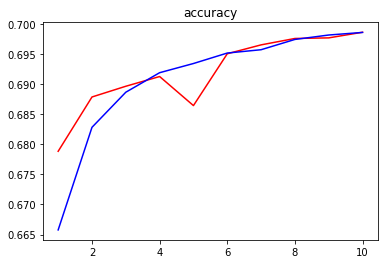

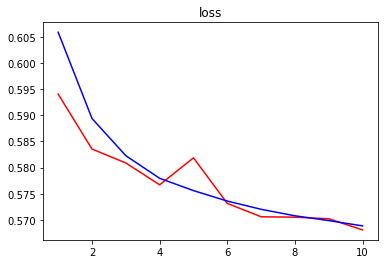

In [33]:
# Try deeper

nUnits = 20
batchsize = 256
nepochs = 10

x0 = Input(shape=(3,))
x1 = Input(shape=(31,4))
inistate = Dense(nUnits, activation = 'relu')(x0)
inistate = Dense(nUnits, activation = 'relu')(inistate)
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
x = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=[x0,x1], outputs=x)
model2.compile(optimizer='adam', metrics=['acc'],
              loss='binary_crossentropy')

history2 = model2.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

xaxis=range(1,len(history2.history['val_acc'])+1)
plt.plot(xaxis, history2.history['val_acc'], 'r', xaxis, history2.history['acc'], 'b')
plt.title('accuracy')
plt.show()

plt.plot(xaxis, history2.history['val_loss'], 'r', xaxis, history2.history['loss'], 'b')
plt.title('loss')
plt.show()

In [34]:
# Look whether I can get the time from history and compare the plots with time on x-axis.

print(history.history)

{'val_loss': [0.59093261358214011, 0.58365979141531266, 0.57849317338995276, 0.57815419910963506, 0.57299554936841535, 0.57568644811424297, 0.57006804103784581, 0.57107461590616737, 0.57068616225834479, 0.56982214651995611, 0.5719684823585951, 0.57005331967347095, 0.56818191185597278, 0.56796854825071774, 0.56651810679415282, 0.5665410573483336, 0.5673803997371144, 0.56586854615774784, 0.56626521198671165, 0.56771297103509977], 'val_acc': [0.68284461090477899, 0.68784190035989634, 0.68945838057808606, 0.6925336355955285, 0.69495835593661937, 0.69347986795346361, 0.69683110739456167, 0.69701838254117843, 0.69712680501093283, 0.69793504511738391, 0.69500763886993955, 0.69849687051082177, 0.69902912619890478, 0.69906855253733591, 0.70034005222522189, 0.70126657140982884, 0.69974865701715461, 0.70082302500994709, 0.70180868363816351, 0.70142427679645347], 'acc': [0.66569451304926819, 0.68228318473812211, 0.68708882885704936, 0.6899483404163953, 0.69275309306247612, 0.69394902820578375, 0.6

In [ ]:
help(history)

In [ ]:
dir(history)

Train on 913093 samples, validate on 101455 samples
Epoch 1/10
275s - loss: 0.6018 - acc: 0.6697 - val_loss: 0.5864 - val_acc: 0.6870
Epoch 2/10
273s - loss: 0.5814 - acc: 0.6887 - val_loss: 0.5770 - val_acc: 0.6935
Epoch 3/10
272s - loss: 0.5758 - acc: 0.6935 - val_loss: 0.5754 - val_acc: 0.6946
Epoch 4/10
273s - loss: 0.5729 - acc: 0.6958 - val_loss: 0.5714 - val_acc: 0.6981
Epoch 5/10
272s - loss: 0.5708 - acc: 0.6972 - val_loss: 0.5713 - val_acc: 0.6965
Epoch 6/10
273s - loss: 0.5691 - acc: 0.6985 - val_loss: 0.5683 - val_acc: 0.6987
Epoch 7/10
273s - loss: 0.5675 - acc: 0.6992 - val_loss: 0.5666 - val_acc: 0.6998
Epoch 8/10
273s - loss: 0.5667 - acc: 0.6998 - val_loss: 0.5653 - val_acc: 0.7007
Epoch 9/10
273s - loss: 0.5654 - acc: 0.7008 - val_loss: 0.5682 - val_acc: 0.6994
Epoch 10/10
273s - loss: 0.5640 - acc: 0.7021 - val_loss: 0.5631 - val_acc: 0.7028


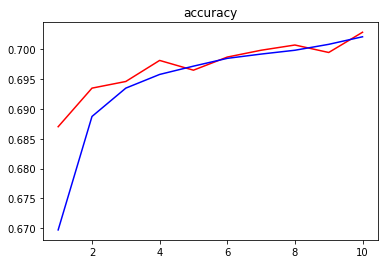

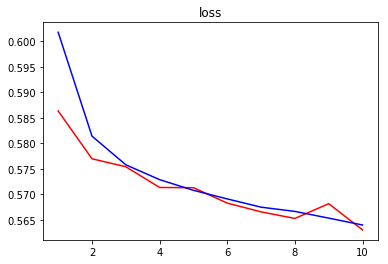

In [35]:
# Try wider

nUnits = 40
batchsize = 256
nepochs = 10

x0 = Input(shape=(3,))
x1 = Input(shape=(31,4))
inistate = Dense(nUnits, activation = 'relu')(x0)
inistate = Dense(nUnits, activation = 'relu')(inistate)
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
x = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=[x0,x1], outputs=x)
model3.compile(optimizer='adam', metrics=['acc'],
              loss='binary_crossentropy')

history3 = model3.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

xaxis=range(1,len(history2.history['val_acc'])+1)
plt.plot(xaxis, history3.history['val_acc'], 'r', xaxis, history3.history['acc'], 'b')
plt.title('accuracy')
plt.show()

plt.plot(xaxis, history3.history['val_loss'], 'r', xaxis, history3.history['loss'], 'b')
plt.title('loss')
plt.show()

In [38]:
print(model.layers)
print(model2.layers)
print(model3.layers)

[<keras.engine.topology.InputLayer object at 0x0000022C586ACA90>, <keras.layers.core.Dense object at 0x0000022C5637B160>, <keras.engine.topology.InputLayer object at 0x0000022C5870E630>, <keras.layers.core.Dense object at 0x0000022C586AC0F0>, <keras.layers.recurrent.GRU object at 0x0000022C5859D710>, <keras.layers.core.Dense object at 0x0000022C5869DBE0>, <keras.layers.recurrent.GRU object at 0x0000022C255B4F60>, <keras.layers.core.Dense object at 0x0000022C255ED860>]
[<keras.engine.topology.InputLayer object at 0x0000022E2864DB70>, <keras.layers.core.Dense object at 0x0000022E2821B390>, <keras.engine.topology.InputLayer object at 0x0000022E2864D780>, <keras.layers.core.Dense object at 0x0000022C048D7EF0>, <keras.layers.recurrent.GRU object at 0x0000022C5894CE48>, <keras.layers.recurrent.GRU object at 0x0000022C58B5CC88>, <keras.layers.core.Dense object at 0x0000022C58D4E710>]
[<keras.engine.topology.InputLayer object at 0x0000022E2DCA1DD8>, <keras.layers.core.Dense object at 0x0000022

In [39]:
# Deeper didn't work because I used x1 rather than x
# Increasing the number of units seems to be useful

nUnits = 80
batchsize = 256
nepochs = 10

x0 = Input(shape=(3,))
x1 = Input(shape=(31,4))
inistate = Dense(nUnits, activation = 'relu')(x0)
inistate = Dense(nUnits, activation = 'relu')(inistate)
x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
x = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=[x0,x1], outputs=x)
model4.compile(optimizer='adam', metrics=['acc'],
              loss='binary_crossentropy')

history4 = model4.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
          validation_data=([X0_val,X1_val], y_val))

xaxis=range(1,len(history4.history['val_acc'])+1)
plt.plot(xaxis, history4.history['val_acc'], 'r', xaxis, history4.history['acc'], 'b')
plt.title('accuracy')
plt.show()

plt.plot(xaxis, history4.history['val_loss'], 'r', xaxis, history4.history['loss'], 'b')
plt.title('loss')
plt.show()

Train on 913093 samples, validate on 101455 samples
Epoch 1/10
671s - loss: 0.5986 - acc: 0.6732 - val_loss: 0.5786 - val_acc: 0.6919
Epoch 2/10
676s - loss: 0.5779 - acc: 0.6915 - val_loss: 0.5762 - val_acc: 0.6950
Epoch 3/10
681s - loss: 0.5726 - acc: 0.6960 - val_loss: 0.5693 - val_acc: 0.6982
Epoch 4/10
670s - loss: 0.5688 - acc: 0.6986 - val_loss: 0.5691 - val_acc: 0.6966
Epoch 5/10
671s - loss: 0.5656 - acc: 0.7009 - val_loss: 0.5644 - val_acc: 0.7008
Epoch 6/10
669s - loss: 0.5674 - acc: 0.6999 - val_loss: 0.5702 - val_acc: 0.6968
Epoch 7/10


KeyboardInterrupt: 

It is long to train and it doesn't seem to progress. I will use a less deep network.

In [17]:
history = []
xaxis = []

import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.start = time.time()
    #def on_epoch_begin(self, batch, logs={}):
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.start)

def fitandplot(nUnits, batchsize, nepochs, nlayer):
    x0 = Input(shape=(3,))
    x1 = Input(shape=(31,4))
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    time_callback = TimeHistory()
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit([X0_train,X1_train], y_train, epochs=nepochs, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback]))

    #xaxis=range(1,len(history[-1].history['val_acc'])+1)
    xaxis.append(time_callback.times)
    plt.plot(xaxis[-1], history[-1].history['val_acc'], 'r', xaxis[-1], history[-1].history['acc'], 'b')
    plt.title('accuracy')
    plt.show()

    plt.plot(xaxis[-1], history[-1].history['val_loss'], 'r', xaxis[-1], history[-1].history['loss'], 'b')
    plt.title('loss')
    plt.show()

Train on 913093 samples, validate on 101455 samples
Epoch 1/5
122s - loss: 0.6174 - acc: 0.6514 - val_loss: 0.5957 - val_acc: 0.6785
Epoch 2/5
119s - loss: 0.5912 - acc: 0.6816 - val_loss: 0.5898 - val_acc: 0.6851
Epoch 3/5
118s - loss: 0.5836 - acc: 0.6873 - val_loss: 0.5802 - val_acc: 0.6907
Epoch 4/5
118s - loss: 0.5797 - acc: 0.6899 - val_loss: 0.5807 - val_acc: 0.6913
Epoch 5/5
118s - loss: 0.5770 - acc: 0.6916 - val_loss: 0.5750 - val_acc: 0.6937


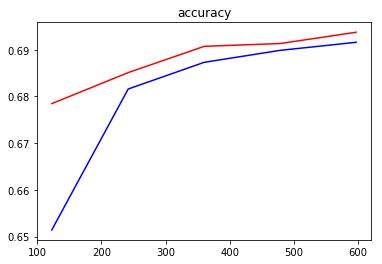

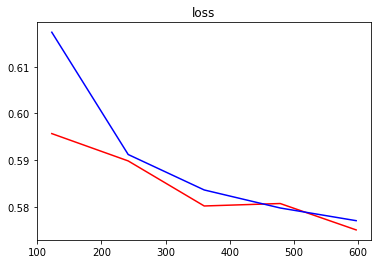

Train on 913093 samples, validate on 101455 samples
Epoch 1/5
159s - loss: 0.6074 - acc: 0.6632 - val_loss: 0.5943 - val_acc: 0.6780
Epoch 2/5
163s - loss: 0.5872 - acc: 0.6840 - val_loss: 0.5819 - val_acc: 0.6894
Epoch 3/5
159s - loss: 0.5796 - acc: 0.6898 - val_loss: 0.5771 - val_acc: 0.6922
Epoch 4/5
160s - loss: 0.5755 - acc: 0.6930 - val_loss: 0.5735 - val_acc: 0.6949
Epoch 5/5
164s - loss: 0.5729 - acc: 0.6953 - val_loss: 0.5728 - val_acc: 0.6952


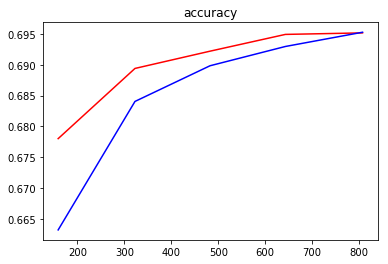

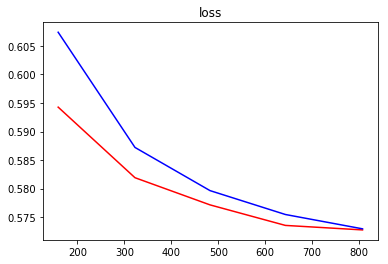

Train on 913093 samples, validate on 101455 samples
Epoch 1/5
278s - loss: 0.6001 - acc: 0.6708 - val_loss: 0.5820 - val_acc: 0.6871
Epoch 2/5
271s - loss: 0.5798 - acc: 0.6891 - val_loss: 0.5762 - val_acc: 0.6924
Epoch 3/5
272s - loss: 0.5750 - acc: 0.6933 - val_loss: 0.5726 - val_acc: 0.6963
Epoch 4/5
282s - loss: 0.5723 - acc: 0.6951 - val_loss: 0.5701 - val_acc: 0.6980
Epoch 5/5
285s - loss: 0.5703 - acc: 0.6972 - val_loss: 0.5713 - val_acc: 0.6967


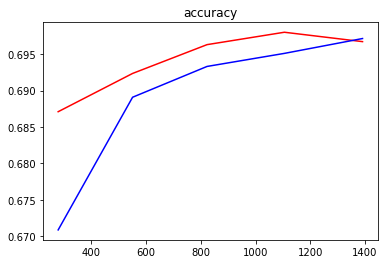

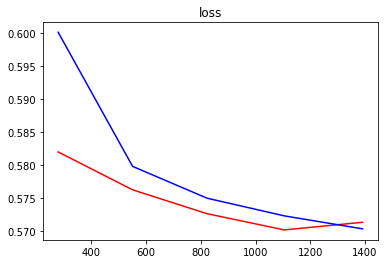

In [18]:
fitandplot(nUnits = 40, batchsize = 1024, nepochs = 5, nlayer = 0)
fitandplot(nUnits = 40, batchsize = 512, nepochs = 5, nlayer = 0)
fitandplot(nUnits = 40, batchsize = 256, nepochs = 5, nlayer = 0)

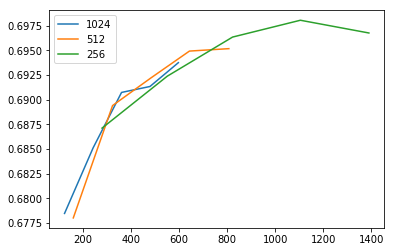

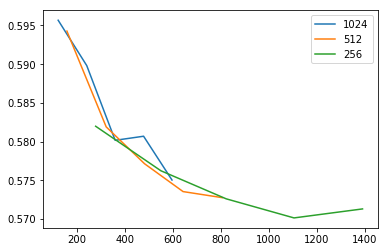

In [22]:
# do all plots
def Plot(i, text = 'acc', label = ''):
    plt.plot(xaxis[i], history[i].history['val_'+text], label = label)
    
Plot(0, 'acc', '1024')
Plot(1, 'acc', '512')
Plot(2, 'acc', '256')
plt.legend()
plt.show()

Plot(0, 'loss', '1024')
Plot(1, 'loss', '512')
Plot(2, 'loss', '256')
plt.legend()
plt.show()

In [26]:
# Replace npochs limit by time stopping callback
from keras.callbacks import Callback
class TimedStopping(Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, verbose=0):
        super(Callback, self).__init__()

        self.start_time = 0
        self.seconds = seconds
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs={}):
        if time.time() - self.start_time > self.seconds:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)
                
def fit(nUnits, batchsize, timelimit, nlayer):
    x0 = Input(shape=(3,))
    x1 = Input(shape=(31,4))
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit([X0_train,X1_train], y_train, epochs=100, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)

Train on 913093 samples, validate on 101455 samples
Epoch 1/100
90s - loss: 0.6420 - acc: 0.6188 - val_loss: 0.6095 - val_acc: 0.6639
Epoch 2/100
86s - loss: 0.6006 - acc: 0.6743 - val_loss: 0.5970 - val_acc: 0.6779
Epoch 3/100
86s - loss: 0.5952 - acc: 0.6784 - val_loss: 0.5917 - val_acc: 0.6814
Epoch 4/100
86s - loss: 0.5906 - acc: 0.6814 - val_loss: 0.5880 - val_acc: 0.6846
Epoch 5/100
86s - loss: 0.5870 - acc: 0.6840 - val_loss: 0.5848 - val_acc: 0.6872
Epoch 6/100
87s - loss: 0.5840 - acc: 0.6863 - val_loss: 0.5849 - val_acc: 0.6858
Epoch 7/100
87s - loss: 0.5819 - acc: 0.6878 - val_loss: 0.5815 - val_acc: 0.6873
Epoch 8/100
87s - loss: 0.5805 - acc: 0.6883 - val_loss: 0.5787 - val_acc: 0.6901
Epoch 9/100
87s - loss: 0.5790 - acc: 0.6898 - val_loss: 0.5779 - val_acc: 0.6907
Epoch 10/100
87s - loss: 0.5784 - acc: 0.6900 - val_loss: 0.5772 - val_acc: 0.6915
Epoch 11/100
87s - loss: 0.5769 - acc: 0.6915 - val_loss: 0.5773 - val_acc: 0.6925
Epoch 12/100
87s - loss: 0.5758 - acc: 0.692

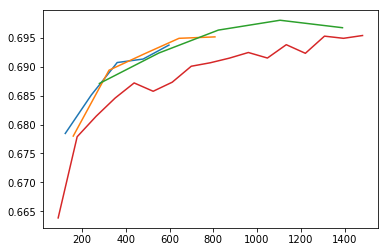

In [27]:
fit(nUnits = 40, batchsize = 4096, timelimit = 1400, nlayer = 0)
Plot(0, 'acc', '1024')
Plot(1, 'acc', '512')
Plot(2, 'acc', '256')
Plot(3, 'acc', '4096')

Train on 913093 samples, validate on 101455 samples
Epoch 1/100
122s - loss: 0.6132 - acc: 0.6556 - val_loss: 0.5955 - val_acc: 0.6789
Epoch 2/100
120s - loss: 0.5897 - acc: 0.6823 - val_loss: 0.5855 - val_acc: 0.6864
Epoch 3/100
120s - loss: 0.5825 - acc: 0.6876 - val_loss: 0.5792 - val_acc: 0.6892
Epoch 4/100
120s - loss: 0.5781 - acc: 0.6907 - val_loss: 0.5760 - val_acc: 0.6937
Epoch 5/100
120s - loss: 0.5752 - acc: 0.6931 - val_loss: 0.5749 - val_acc: 0.6933
Epoch 6/100
120s - loss: 0.5732 - acc: 0.6947 - val_loss: 0.5727 - val_acc: 0.6956
Epoch 7/100
120s - loss: 0.5714 - acc: 0.6964 - val_loss: 0.5715 - val_acc: 0.6972
Epoch 8/100
120s - loss: 0.5704 - acc: 0.6974 - val_loss: 0.5701 - val_acc: 0.6973
Epoch 9/100
120s - loss: 0.5692 - acc: 0.6986 - val_loss: 0.5703 - val_acc: 0.6979
Epoch 10/100
120s - loss: 0.5685 - acc: 0.6988 - val_loss: 0.5674 - val_acc: 0.7000
Epoch 11/100
120s - loss: 0.5676 - acc: 0.6994 - val_loss: 0.5674 - val_acc: 0.6996
Epoch 12/100
120s - loss: 0.5668 

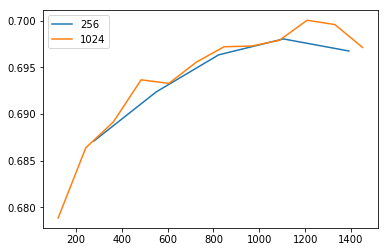

In [30]:
fit(nUnits = 40, batchsize = 1024, timelimit = 1400, nlayer = 0)
Plot(2, 'acc', '256')
Plot(4, 'acc', '1024')
plt.legend()

Train on 913093 samples, validate on 101455 samples
Epoch 1/100
129s - loss: 0.6097 - acc: 0.6598 - val_loss: 0.5920 - val_acc: 0.6809
Epoch 2/100
126s - loss: 0.5861 - acc: 0.6848 - val_loss: 0.5821 - val_acc: 0.6865
Epoch 3/100
126s - loss: 0.5777 - acc: 0.6911 - val_loss: 0.5744 - val_acc: 0.6950
Epoch 4/100
126s - loss: 0.5736 - acc: 0.6946 - val_loss: 0.5752 - val_acc: 0.6953
Epoch 5/100
122s - loss: 0.5711 - acc: 0.6966 - val_loss: 0.5737 - val_acc: 0.6971
Epoch 6/100
122s - loss: 0.5695 - acc: 0.6979 - val_loss: 0.5688 - val_acc: 0.6989
Epoch 7/100
121s - loss: 0.5679 - acc: 0.6990 - val_loss: 0.5665 - val_acc: 0.7009
Epoch 8/100
121s - loss: 0.5663 - acc: 0.7000 - val_loss: 0.5647 - val_acc: 0.7015
Epoch 9/100
122s - loss: 0.5651 - acc: 0.7007 - val_loss: 0.5641 - val_acc: 0.7019
Epoch 10/100
122s - loss: 0.5638 - acc: 0.7016 - val_loss: 0.5649 - val_acc: 0.7033
Epoch 11/100
122s - loss: 0.5625 - acc: 0.7027 - val_loss: 0.5626 - val_acc: 0.7043
Epoch 12/100
122s - loss: 0.5613 

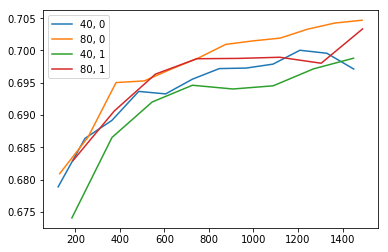

In [31]:
# then test with nUnits = 80 and/or nlayer = 
fit(nUnits = 80, batchsize = 1024, timelimit = 1400, nlayer = 0)
fit(nUnits = 40, batchsize = 1024, timelimit = 1400, nlayer = 1)
fit(nUnits = 80, batchsize = 1024, timelimit = 1400, nlayer = 1)
Plot(4, 'acc', '40, 0')
Plot(5, 'acc', '80, 0')
Plot(6, 'acc', '40, 1')
Plot(7, 'acc', '80, 1')
plt.legend()

In [32]:
# To be able to continue training I add
modelList = [] # There's already 7 models in history and xaxis, so modelList[1] correspond to history[8]

def fit(nUnits, batchsize, timelimit, nlayer):
    x0 = Input(shape=(3,))
    x1 = Input(shape=(31,4))
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit([X0_train,X1_train], y_train, epochs=100, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model) 

In [37]:
refit_history = []
refit_xaxis = []
def refit(batchsize, timelimit, model):
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    refit_history.append(model.fit([X0_train,X1_train], y_train, epochs=200, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping, es]))
    refit_xaxis.append(time_callback.times)

Train on 913093 samples, validate on 101455 samples
Epoch 1/100
222s - loss: 0.6092 - acc: 0.6600 - val_loss: 0.5880 - val_acc: 0.6839
Epoch 2/100
215s - loss: 0.5826 - acc: 0.6878 - val_loss: 0.5796 - val_acc: 0.6903
Epoch 3/100
216s - loss: 0.5748 - acc: 0.6940 - val_loss: 0.5718 - val_acc: 0.6957
Epoch 4/100
215s - loss: 0.5716 - acc: 0.6962 - val_loss: 0.5700 - val_acc: 0.6975
Epoch 5/100
216s - loss: 0.5690 - acc: 0.6979 - val_loss: 0.5716 - val_acc: 0.6967
Epoch 6/100
216s - loss: 0.5670 - acc: 0.6995 - val_loss: 0.5685 - val_acc: 0.6987
Epoch 7/100
216s - loss: 0.5646 - acc: 0.7011 - val_loss: 0.5644 - val_acc: 0.7023
Epoch 8/100
217s - loss: 0.5627 - acc: 0.7024 - val_loss: 0.5667 - val_acc: 0.6991
Epoch 9/100
216s - loss: 0.5603 - acc: 0.7042 - val_loss: 0.5644 - val_acc: 0.7005
Epoch 10/100
216s - loss: 0.5579 - acc: 0.7064 - val_loss: 0.5599 - val_acc: 0.7044
Train on 913093 samples, validate on 101455 samples
Epoch 1/100
331s - loss: 0.6070 - acc: 0.6627 - val_loss: 0.5875 

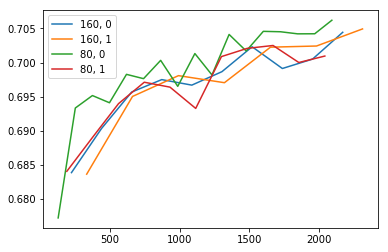

In [33]:
fit(nUnits = 160, batchsize = 1024, timelimit = 2000, nlayer = 0)
fit(nUnits = 160, batchsize = 1024, timelimit = 2000, nlayer = 1)
fit(nUnits = 80, batchsize = 1024, timelimit = 2000, nlayer = 0)
fit(nUnits = 80, batchsize = 1024, timelimit = 2000, nlayer = 1)
Plot(8, 'acc', '160, 0')
Plot(9, 'acc', '160, 1')
Plot(10, 'acc', '80, 0')
Plot(11, 'acc', '80, 1')
plt.legend()

In [34]:
# Save the 4 models
i = 0
for model in modelList:
    model.save('model'+str(i))
    i+=1

In [38]:
# continue models with early stopping and max 1 hour each
for model in modelList:
    refit(1024, 3600, model)

Train on 913093 samples, validate on 101455 samples
Epoch 1/200
218s - loss: 0.5553 - acc: 0.7081 - val_loss: 0.5576 - val_acc: 0.7058
Epoch 2/200
216s - loss: 0.5526 - acc: 0.7101 - val_loss: 0.5556 - val_acc: 0.7077
Epoch 3/200
216s - loss: 0.5500 - acc: 0.7121 - val_loss: 0.5554 - val_acc: 0.7103
Epoch 4/200
216s - loss: 0.5472 - acc: 0.7143 - val_loss: 0.5543 - val_acc: 0.7092
Epoch 5/200
216s - loss: 0.5442 - acc: 0.7164 - val_loss: 0.5527 - val_acc: 0.7116
Epoch 6/200
217s - loss: 0.5415 - acc: 0.7188 - val_loss: 0.5512 - val_acc: 0.7125
Epoch 7/200
217s - loss: 0.5384 - acc: 0.7208 - val_loss: 0.5540 - val_acc: 0.7090
Epoch 8/200
217s - loss: 0.5359 - acc: 0.7228 - val_loss: 0.5512 - val_acc: 0.7122
Epoch 9/200
217s - loss: 0.5330 - acc: 0.7249 - val_loss: 0.5529 - val_acc: 0.7122
Epoch 10/200
217s - loss: 0.5302 - acc: 0.7272 - val_loss: 0.5537 - val_acc: 0.7114
Epoch 11/200
216s - loss: 0.5275 - acc: 0.7289 - val_loss: 0.5524 - val_acc: 0.7111
Epoch 12/200
216s - loss: 0.5240 

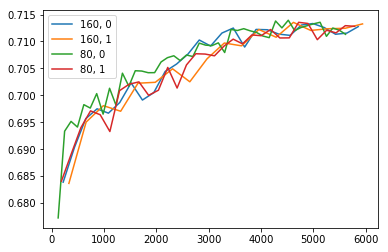

In [42]:
def Plot2(i, j, text = 'acc', label = ''):
    plt.plot(xaxis[i]+[t+xaxis[i][-1] for t in refit_xaxis[j]]
             , history[i].history['val_'+text]+refit_history[j].history['val_'+text], label = label)
    
Plot2(8, 0, 'acc', '160, 0')
Plot2(9, 1, 'acc', '160, 1')
Plot2(10, 2, 'acc', '80, 0')
Plot2(11, 3, 'acc', '80, 1')
plt.legend()

(0.705, 0.715)

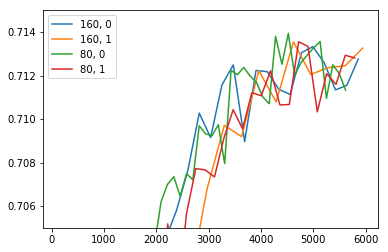

In [43]:
Plot2(8, 0, 'acc', '160, 0')
Plot2(9, 1, 'acc', '160, 1')
Plot2(10, 2, 'acc', '80, 0')
Plot2(11, 3, 'acc', '80, 1')
plt.legend()
plt.ylim((0.705,0.715))

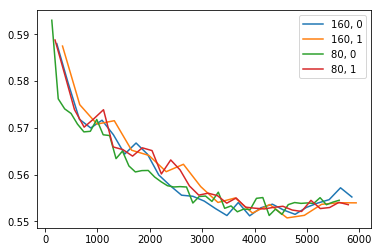

In [48]:
Plot2(8, 0, 'loss', '160, 0')
Plot2(9, 1, 'loss', '160, 1')
Plot2(10, 2, 'loss', '80, 0')
Plot2(11, 3, 'loss', '80, 1')
plt.legend()

(0.55, 0.56)

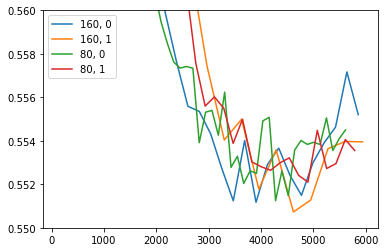

In [50]:
Plot2(8, 0, 'loss', '160, 0')
Plot2(9, 1, 'loss', '160, 1')
Plot2(10, 2, 'loss', '80, 0')
Plot2(11, 3, 'loss', '80, 1')
plt.legend()
plt.ylim((0.55,0.56))

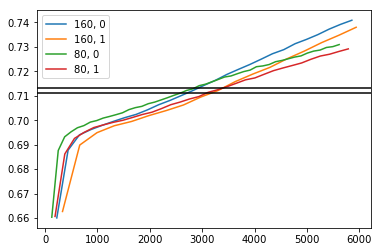

In [47]:
# plot training error to see if there is overfitting
def Plot3(i, j, text = 'acc', label = ''):
    plt.plot(xaxis[i]+[t+xaxis[i][-1] for t in refit_xaxis[j]]
             , history[i].history[text]+refit_history[j].history[text], label = label)
    
Plot3(8, 0, 'acc', '160, 0')
Plot3(9, 1, 'acc', '160, 1')
Plot3(10, 2, 'acc', '80, 0')
Plot3(11, 3, 'acc', '80, 1')
#plt.ylim((0.705,0.715))
plt.axhline(y=0.711, color='k', linestyle='-')
plt.axhline(y=0.713, color='k', linestyle='-') # correspond approximatively at where the validation error is.
plt.legend()

It seems that all those 4 models learn at the same speed. They might have converged since the val_loss is starting to increase, though I should still try for a longer period.

For the training error, the differences between the models are bigger. They are also significatively higher than the validation error, which is normal since there should be some overfitting. They are very far from 1, so there is still room for more learning.

I will continue with (80,1) because it is the one that seems to have the less overfitting and it's val_loss didn't increase much so there is more hope of improvement.

In [51]:
refit(1024, 3600, modelList[3])  # It will create refit_history[4]

Train on 913093 samples, validate on 101455 samples
Epoch 1/200
188s - loss: 0.5251 - acc: 0.7299 - val_loss: 0.5545 - val_acc: 0.7131
Epoch 2/200
183s - loss: 0.5236 - acc: 0.7313 - val_loss: 0.5536 - val_acc: 0.7113
Epoch 3/200
180s - loss: 0.5225 - acc: 0.7318 - val_loss: 0.5569 - val_acc: 0.7095
Epoch 4/200
180s - loss: 0.5211 - acc: 0.7325 - val_loss: 0.5552 - val_acc: 0.7115
Epoch 5/200
179s - loss: 0.5196 - acc: 0.7341 - val_loss: 0.5562 - val_acc: 0.7125
Epoch 6/200
180s - loss: 0.5183 - acc: 0.7346 - val_loss: 0.5558 - val_acc: 0.7128
Epoch 7/200
180s - loss: 0.5171 - acc: 0.7353 - val_loss: 0.5575 - val_acc: 0.7116
Epoch 8/200
178s - loss: 0.5157 - acc: 0.7364 - val_loss: 0.5577 - val_acc: 0.7111
Epoch 9/200
179s - loss: 0.5145 - acc: 0.7375 - val_loss: 0.5564 - val_acc: 0.7123
Epoch 10/200
180s - loss: 0.5132 - acc: 0.7383 - val_loss: 0.5590 - val_acc: 0.7119
Epoch 11/200
180s - loss: 0.5121 - acc: 0.7388 - val_loss: 0.5579 - val_acc: 0.7110
Epoch 12/200
181s - loss: 0.5108 

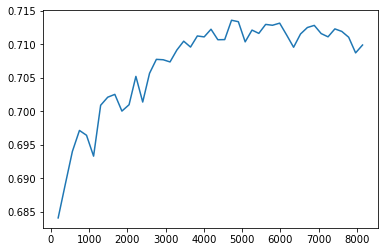

In [54]:
plt.plot(xaxis[11]+[t+xaxis[11][-1] for t in refit_xaxis[3]]+[t+xaxis[11][-1]+refit_xaxis[3][-1] for t in refit_xaxis[4]]
        , history[11].history['val_acc']+refit_history[3].history['val_acc']+refit_history[4].history['val_acc'])

So it seems that 5000 s is enough to fit a model and that the maximum accuracy is around 71%. Increasing the number of units and layers didn't seem to help, so I will have to increase the number of feature and the number of data.

I should look how the model read the features to see if it's using them well.

In [55]:
# Resave the 4 models
i = 0
for model in modelList:
    model.save('model'+str(i))
    i+=1

# Use more data

# Need to choose if I want to use num_cause to do learning only on lightning

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

from keras.models import Model
from keras.layers import GRU, concatenate, Input, Dense

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [4]:
df = pd.DataFrame(np.load('NewFireData.npy'), columns=['day', 'lat', 'lon', 'num_cause', 'tarray', 'xybinarray', 'fire'])

display(df.describe())

,day,lat,lon,num_cause,tarray,xybinarray,fire
count,3671292,3.671292e+06,3.671292e+06,1835646.0,3671292,3671292,3671292
unique,366,8.772090e+05,9.802780e+05,4.0,8766,4780,2
top,185,4.786660e+01,-1.104518e+02,3.0,6249,4764,True
freq,26131,1.884000e+03,1.584000e+03,853806.0,2388,16755,1835646


In [5]:
weatherData = np.concatenate((np.load('weatherData1991.npy'),np.load('FullweatherData.npy'),np.load('weatherData2000_04.npy'),
                             np.load('weatherData2005_09.npy'),np.load('weatherData2010_15.npy')))
df = (pd.DataFrame(np.load('NewFireData.npy'), columns=['day', 'lat', 'lon', 'num_cause', 'tarray', 'xybinarray', 'fire'])
      .drop('num_cause',axis=1).astype(int, copy=False))

def moddf(df):
    df0 = df.drop(['tarray', 'xybinarray'],axis=1).values
    df0 = (df0-df0.mean())/ df0.std()
    
    tarray = df['tarray'].values
    xybinarray = df['xybinarray'].values
    df1 = np.empty((len(df),31,4))
    for i in range(0,31):
        for j in range(0,4):
            df1[:,i,j] = weatherData[tarray-i, xybinarray,j]
    # Normalize features
    df1 = (df1-df1.mean())/ df1.std()
    
    return df0, df1

xdf = df.drop('fire',axis=1)
y = df['fire'].values
x0, x1 = moddf(xdf)
X0, X0_test, X1, X1_test, y, y_test = train_test_split(
    x0, x1, y, test_size=0.1, shuffle=True)
X0_train, X0_val, X1_train, X1_val, y_train, y_val = train_test_split(
    X0, X1, y, test_size=0.1, shuffle=True)

In [8]:
# The model saving didn't work.

# TO DO: Find out why

from keras.models import load_model
model = load_model('model3')
model.summary()

ValueError: Layer gru_40 expects 1 inputs, but it received 2 input tensors. Input received: [<tf.Tensor 'input_38_1:0' shape=(?, 31, 4) dtype=float32>, <tf.Tensor 'dense_57_1/Relu:0' shape=(?, 80) dtype=float32>]

In [18]:
modelList = [] # There's already 7 models in history and xaxis, so modelList[1] correspond to history[8]
history = []
xaxis = []
def fit(nUnits, batchsize, timelimit, nlayer):
    x0 = Input(shape=(3,))
    x1 = Input(shape=(31,4))
    # first
    inistate = Dense(nUnits, activation = 'relu')(x0)
    x = GRU(nUnits, return_sequences=True)(x1, initial_state = inistate) 
    # nlayer middle layers
    for _ in range(nlayer): 
        inistate = Dense(nUnits, activation = 'relu')(inistate)
        x = GRU(nUnits, return_sequences=True)(x, initial_state = inistate) 
    # last
    inistate = Dense(nUnits, activation = 'relu')(inistate)
    x = GRU(nUnits, return_sequences=False)(x, initial_state = inistate) 
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[x0,x1], outputs=x)
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    model.compile(optimizer='adam', metrics=['acc'],
                  loss='binary_crossentropy')
    history.append(model.fit([X0_train,X1_train], y_train, epochs=100, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping]))
    xaxis.append(time_callback.times)
    modelList.append(model) 
    
refit_history = []
refit_xaxis = []
def refit(batchsize, timelimit, model):
    time_callback = TimeHistory()
    timed_stopping = TimedStopping(timelimit)
    es = EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    refit_history.append(model.fit([X0_train,X1_train], y_train, epochs=200, batch_size=batchsize,verbose=2, shuffle=True, 
              validation_data=([X0_val,X1_val], y_val),callbacks=[time_callback, timed_stopping, es]))
    refit_xaxis.append(time_callback.times)

In [ ]:
import time
import keras
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.start = time.time()
    #def on_epoch_begin(self, batch, logs={}):
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.start)
        
from keras.callbacks import Callback
class TimedStopping(Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, verbose=0):
        super(Callback, self).__init__()

        self.start_time = 0
        self.seconds = seconds
        self.verbose = verbose
    def on_train_begin(self, logs={}):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs={}):
        if time.time() - self.start_time > self.seconds:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)

fit(nUnits = 80, batchsize = 1024, timelimit = 8000, nlayer = 1)

In [ ]:
def Plot(i, text = 'acc', label = ''):
    plt.plot(xaxis[i], history[i].history['val_'+text], label = label)
def Plot2(i, j, text = 'acc', label = ''):
    plt.plot(xaxis[i]+[t+xaxis[i][-1] for t in refit_xaxis[j]]
             , history[i].history['val_'+text]+refit_history[j].history['val_'+text], label = label)
    
Plot(0, 'acc', '80, 1')
plt.legend()